In [27]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import datasets
from tensorflow.keras.losses import MeanSquaredError, KLDivergence, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from numpy import cov, trace, iscomplexobj, asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize


In [4]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [7]:
latent_dim = 1024
image_shape = x_train[0].shape
mse_loss = MeanSquaredError()
kl_loss = KLDivergence()

In [8]:
class VAE(keras.Model):
    def __init__(self, latent_dim, image_shape, beta):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.image_shape = image_shape
        self.beta = beta

        # encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=image_shape, name="Encoder_Input_Layer"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_1"),
            layers.Conv2D(32, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_2"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_2"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_3"),
            layers.Conv2D(64, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_4"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_4"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_5"),
            layers.Conv2D(128, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_6"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_6"),

            layers.Flatten(name="Encoder_Flatten"),
            # layers.Dense(512,  name="Encoder_Dense_1"),
        ])
        
        # reparameterization/sampling layer 
        self.z_mean = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")
        
        # decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(8*8*64, activation='relu'),
            layers.Reshape((8, 8, 64)),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
        ])
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
     
    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var
    
    # Build the reparameterization/sampling layer 
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z
    
    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar
    
    def decode(self, data):
        return self.decoder(data)
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def recon_loss(self, data, reconstruction):
        return tf.reduce_mean(binary_crossentropy(data, reconstruction))

    def kl_divergence(self, Z_logvar, Z_mu):
        kl = -0.5 * tf.reduce_mean(1 + Z_logvar - Z_mu**2 - tf.math.exp(Z_logvar))
        return self.beta * kl

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)      
            reconstruction = self.decode(z)

            reconstruction_loss = self.recon_loss(data, reconstruction)
            kl_loss = self.kl_divergence(z_log_var, z_mean)
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [35]:
vae = VAE(latent_dim,  image_shape, 0.3)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [10]:
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = vae.fit(x_train, epochs=50, batch_size=512, callbacks=[early_stopping])

Epoch 1/50
 5/98 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - kl_loss: 3.8707e-04 - loss: 0.6934 - reconstruction_loss: 0.6930

I0000 00:00:1715111756.167512     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715111756.186528     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715111756.189170     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715111756.190190     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - kl_loss: 6.3835e-04 - loss: 0.6879 - reconstruction_loss: 0.6871 - total_loss: 0.6754
Epoch 2/50
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0058 - loss: 0.6349 - reconstruction_loss: 0.6291

W0000 00:00:1715111762.995440     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715111762.998223     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `loss` which is not available. Available metrics are: kl_loss,reconstruction_loss,total_loss
  current = self.get_monitor_value(logs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0075 - loss: 0.6294 - reconstruction_loss: 0.6219 - total_loss: 0.6254
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0105 - loss: 0.6196 - reconstruction_loss: 0.6092 - total_loss: 0.6185
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0123 - loss: 0.6142 - reconstruction_loss: 0.6019 - total_loss: 0.6138
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0131 - loss: 0.6121 - reconstruction_loss: 0.5990 - total_loss: 0.6117
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0135 - loss: 0.6106 - reconstruction_loss: 0.5971 - total_loss: 0.6105
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0139 - loss: 0.6094 - reconstruction_loss: 0.5956 - total_loss: 0.6091
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0138 - loss: 0.6075 - reconstruction_loss: 0.5937 - total_loss: 0.6070
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.01

In [21]:
def generate_images_from_latent_vectors(vae, num_images_to_generate):
    # Generate random latent vectors
    random_latent_vectors = np.random.normal(size=(num_images_to_generate, latent_dim))

    # Decode the latent vectors to generate images
    generated_images = vae.decoder.predict(random_latent_vectors)

    return generated_images

# Generate images from random latent vectors
generated_images = generate_images_from_latent_vectors(vae, 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


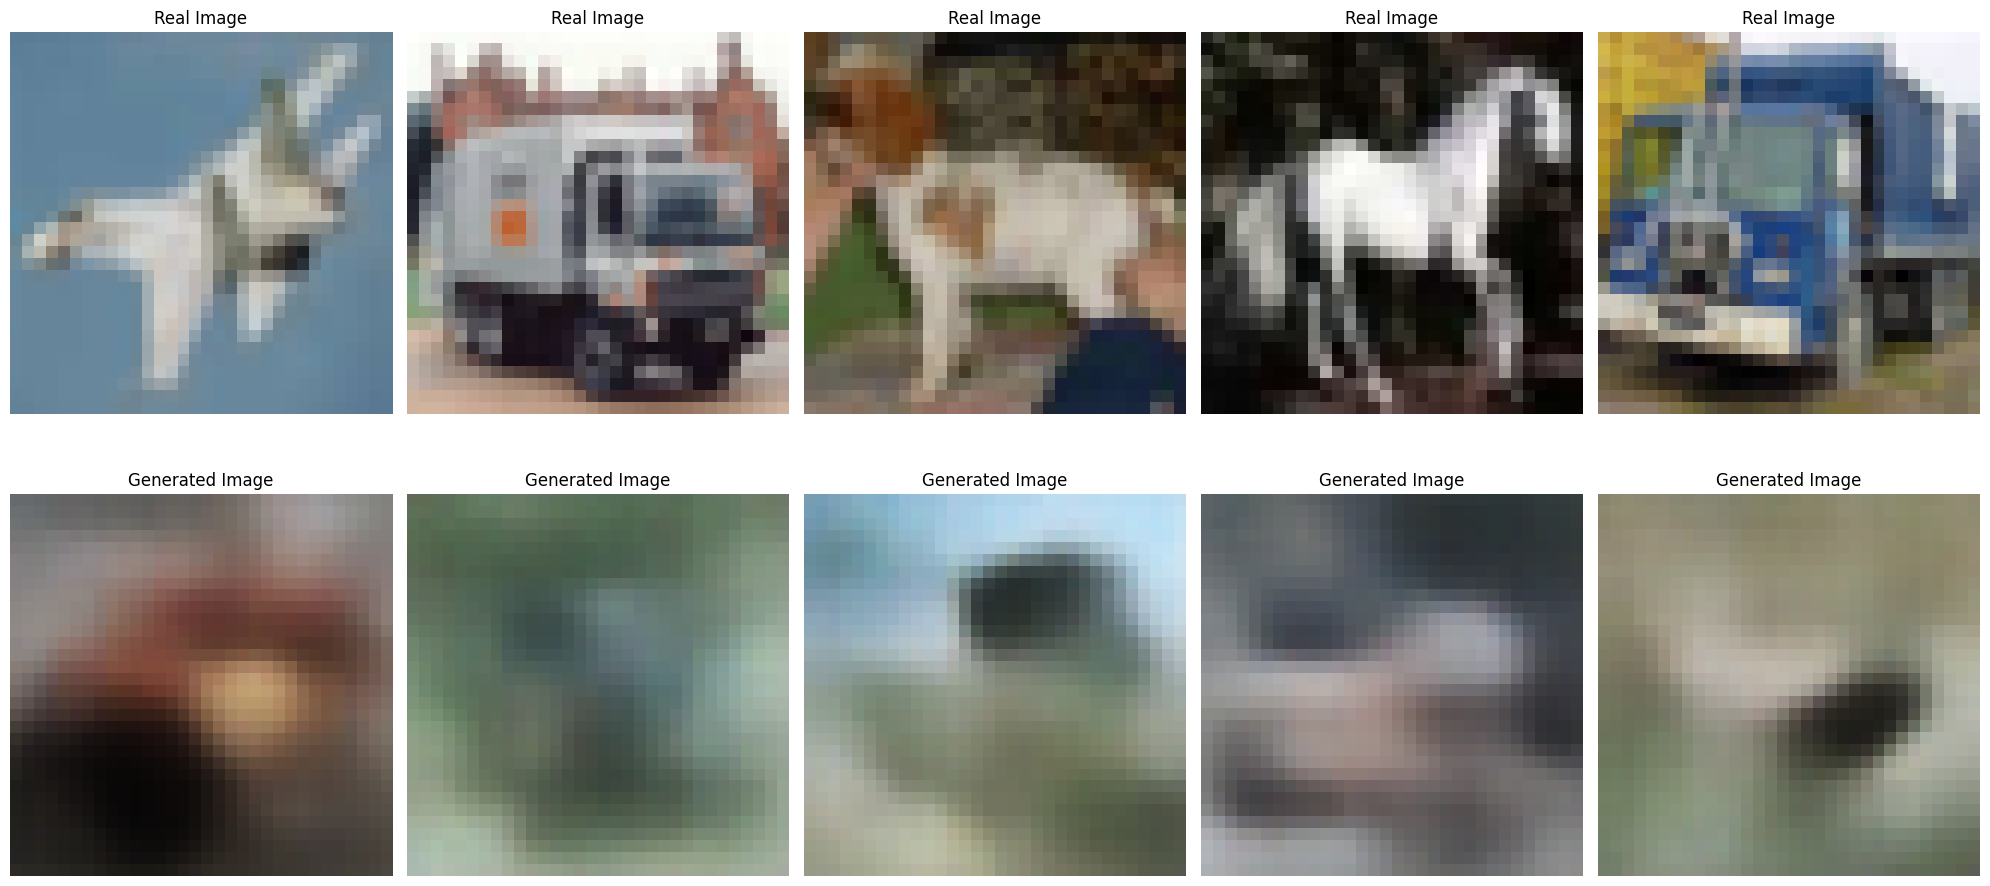

In [23]:
def plot_real_and_generated_images(real_images, generated_images, num_images_to_generate):
    plt.figure(figsize=(20, 10))

    # Plot real images
    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, i + 1)
        plt.imshow(real_images[i+10])
        plt.title('Real Image')
        plt.axis('off')

    # Plot generated images
    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, num_images_to_generate + i + 1)
        plt.imshow(generated_images[i+10])
        plt.title('Generated Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Plot real and generated images side by side vertically
plot_real_and_generated_images(x_test, generated_images, 5)

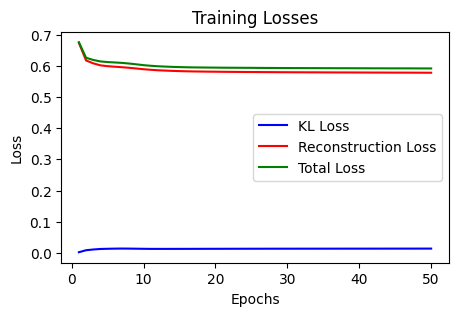

In [24]:
kl_loss = history.history['kl_loss']
reconstruction_loss = history.history['reconstruction_loss']
total_loss = history.history['total_loss']

# Plot the losses
epochs = range(1, len(kl_loss) + 1)

plt.figure(figsize=(5, 3))
plt.plot(epochs, kl_loss, 'b', label='KL Loss')
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction Loss')
plt.plot(epochs, total_loss, 'g', label='Total Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Define list of beta values to try
beta_values = [0.0001, 0.001 ,0.01, 0.1, 0.2, 0.5, 0.7, 1.0, 1.5, 2.3]

# Initialize lists to store losses and generated images
loss_histories = []
generated_images_list = []

# Iterate over each beta value
for beta in beta_values:
    print(f"Beta: {beta}")
    # Train the model
    vae1 = VAE(latent_dim, image_shape, beta)
    vae1.compile(optimizer=keras.optimizers.Adam())
    early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
    history = vae1.fit(x_train, epochs=30, batch_size=512, callbacks=[early_stopping], verbose=1)
    
    # Store training history for each loss
    loss_histories.append(history.history)
    
    # Generate images
    generated_images = generate_images_from_latent_vectors(vae1, 5)
    
    # Store generated images
    generated_images_list.append(generated_images)

Beta: 0.0001
Epoch 1/30
 6/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - kl_loss: 6.9130e-08 - loss: 0.6924 - reconstruction_loss: 0.6924

W0000 00:00:1715112673.248184     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112673.251012     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112673.252002     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - kl_loss: 2.5757e-05 - loss: 0.6740 - reconstruction_loss: 0.6738 - total_loss: 0.6557
Epoch 2/30
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 8.9167e-05 - loss: 0.6261 - reconstruction_loss: 0.6260

W0000 00:00:1715112677.937840     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112677.940640     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 8.2274e-05 - loss: 0.6092 - reconstruction_loss: 0.6090 - total_loss: 0.6024
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 1.9452e-04 - loss: 0.5870 - reconstruction_loss: 0.5868 - total_loss: 0.5846
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 2.7035e-04 - loss: 0.5757 - reconstruction_loss: 0.5754 - total_loss: 0.5744
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 2.9620e-04 - loss: 0.5720 - reconstruction_loss: 0.5717 - total_loss: 0.5706
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 3.1281e-04 - loss: 0.5684 - reconstruction_loss: 0.5680 - total_loss: 0.5679
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 3.2624e-04 - loss: 0.5657 - reconstruction_loss: 0.5654 - total_loss: 0.5653
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 3.2532e-04 - loss: 0.5651 - reconstruction_loss: 0.5648 - total_loss: 0.5643
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 

W0000 00:00:1715112750.822439     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112750.826862     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112750.828296     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - kl_loss: 2.2936e-04 - loss: 0.6714 - reconstruction_loss: 0.6709 - total_loss: 0.6474
Epoch 2/30
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 7.2685e-04 - loss: 0.6011 - reconstruction_loss: 0.6004

W0000 00:00:1715112755.518230     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112755.521106     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 9.4450e-04 - loss: 0.5962 - reconstruction_loss: 0.5952 - total_loss: 0.5921
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0013 - loss: 0.5872 - reconstruction_loss: 0.5858 - total_loss: 0.5835
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0017 - loss: 0.5749 - reconstruction_loss: 0.5732 - total_loss: 0.5737
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0017 - loss: 0.5712 - reconstruction_loss: 0.5695 - total_loss: 0.5703
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0018 - loss: 0.5677 - reconstruction_loss: 0.5660 - total_loss: 0.5676
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0018 - loss: 0.5660 - reconstruction_loss: 0.5642 - total_loss: 0.5662
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0019 - loss: 0.5649 - reconstruction_loss: 0.5629 - total_loss: 0.5642
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 

W0000 00:00:1715112828.389212     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112828.391800     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112828.392768     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 6.5086e-04 - loss: 0.6795 - reconstruction_loss: 0.6787 - total_loss: 0.6624
Epoch 2/30
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0018 - loss: 0.6302 - reconstruction_loss: 0.6284

W0000 00:00:1715112833.110752     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112833.113505     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0023 - loss: 0.6143 - reconstruction_loss: 0.6120 - total_loss: 0.6042
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0034 - loss: 0.5927 - reconstruction_loss: 0.5893 - total_loss: 0.5892
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0038 - loss: 0.5826 - reconstruction_loss: 0.5787 - total_loss: 0.5819
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0040 - loss: 0.5797 - reconstruction_loss: 0.5756 - total_loss: 0.5786
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0041 - loss: 0.5767 - reconstruction_loss: 0.5726 - total_loss: 0.5762
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0043 - loss: 0.5741 - reconstruction_loss: 0.5698 - total_loss: 0.5740
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0043 - loss: 0.5723 - reconstruction_loss: 0.5680 - total_loss: 0.5724
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.00

W0000 00:00:1715112906.125306     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112906.127996     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112906.128978     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 8.8282e-04 - loss: 0.6839 - reconstruction_loss: 0.6828 - total_loss: 0.6660
Epoch 2/30
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0047 - loss: 0.6219 - reconstruction_loss: 0.6172

W0000 00:00:1715112910.887084     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112910.890156     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0058 - loss: 0.6167 - reconstruction_loss: 0.6109 - total_loss: 0.6136
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0078 - loss: 0.6069 - reconstruction_loss: 0.5991 - total_loss: 0.6042
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0092 - loss: 0.5994 - reconstruction_loss: 0.5902 - total_loss: 0.5987
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0097 - loss: 0.5971 - reconstruction_loss: 0.5874 - total_loss: 0.5961
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0098 - loss: 0.5939 - reconstruction_loss: 0.5841 - total_loss: 0.5936
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0096 - loss: 0.5914 - reconstruction_loss: 0.5818 - total_loss: 0.5906
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0094 - loss: 0.5892 - reconstruction_loss: 0.5798 - total_loss: 0.5886
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.00

W0000 00:00:1715112983.768444     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112983.771240     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112983.772303     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 8.2277e-04 - loss: 0.6858 - reconstruction_loss: 0.6849 - total_loss: 0.6696
Epoch 2/30
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0066 - loss: 0.6272 - reconstruction_loss: 0.6206

W0000 00:00:1715112988.538945     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715112988.541767     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0074 - loss: 0.6219 - reconstruction_loss: 0.6144 - total_loss: 0.6195
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0097 - loss: 0.6142 - reconstruction_loss: 0.6044 - total_loss: 0.6123
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0113 - loss: 0.6083 - reconstruction_loss: 0.5970 - total_loss: 0.6073
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - kl_loss: 0.0120 - loss: 0.6056 - reconstruction_loss: 0.5936 - total_loss: 0.6052
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0124 - loss: 0.6040 - reconstruction_loss: 0.5916 - total_loss: 0.6036
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0125 - loss: 0.6019 - reconstruction_loss: 0.5894 - total_loss: 0.6013
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0121 - loss: 0.5989 - reconstruction_loss: 0.5868 - total_loss: 0.5985
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.01

W0000 00:00:1715113061.986652     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113061.989483     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113061.990487     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - kl_loss: 2.2213e-04 - loss: 0.6909 - reconstruction_loss: 0.6906 - total_loss: 0.6870
Epoch 2/30
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0040 - loss: 0.6684 - reconstruction_loss: 0.6644

W0000 00:00:1715113066.710970     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113066.714013     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0066 - loss: 0.6490 - reconstruction_loss: 0.6423 - total_loss: 0.6379
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0118 - loss: 0.6268 - reconstruction_loss: 0.6150 - total_loss: 0.6258
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0131 - loss: 0.6238 - reconstruction_loss: 0.6107 - total_loss: 0.6231
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0144 - loss: 0.6208 - reconstruction_loss: 0.6064 - total_loss: 0.6201
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0149 - loss: 0.6192 - reconstruction_loss: 0.6043 - total_loss: 0.6189
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0153 - loss: 0.6181 - reconstruction_loss: 0.6028 - total_loss: 0.6182
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0156 - loss: 0.6173 - reconstruction_loss: 0.6017 - total_loss: 0.6176
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.01

W0000 00:00:1715113139.760859     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113139.763912     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113139.765123     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 3.2150e-04 - loss: 0.6905 - reconstruction_loss: 0.6902 - total_loss: 0.6852
Epoch 2/30
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0071 - loss: 0.6564 - reconstruction_loss: 0.6493

W0000 00:00:1715113144.512466     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113144.515349     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0083 - loss: 0.6437 - reconstruction_loss: 0.6353 - total_loss: 0.6380
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0126 - loss: 0.6315 - reconstruction_loss: 0.6188 - total_loss: 0.6304
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0139 - loss: 0.6291 - reconstruction_loss: 0.6153 - total_loss: 0.6285
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0152 - loss: 0.6260 - reconstruction_loss: 0.6107 - total_loss: 0.6257
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0158 - loss: 0.6244 - reconstruction_loss: 0.6086 - total_loss: 0.6245
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0160 - loss: 0.6241 - reconstruction_loss: 0.6081 - total_loss: 0.6240
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0163 - loss: 0.6237 - reconstruction_loss: 0.6073 - total_loss: 0.6235
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.01

W0000 00:00:1715113217.142919     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113217.145683     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113217.146705     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 2.0403e-04 - loss: 0.6906 - reconstruction_loss: 0.6904 - total_loss: 0.6876
Epoch 2/30
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0053 - loss: 0.6640 - reconstruction_loss: 0.6587

W0000 00:00:1715113221.888294     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113221.891260     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0088 - loss: 0.6489 - reconstruction_loss: 0.6400 - total_loss: 0.6430
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0136 - loss: 0.6365 - reconstruction_loss: 0.6229 - total_loss: 0.6358
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0147 - loss: 0.6346 - reconstruction_loss: 0.6199 - total_loss: 0.6342
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0157 - loss: 0.6334 - reconstruction_loss: 0.6177 - total_loss: 0.6325
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0167 - loss: 0.6311 - reconstruction_loss: 0.6143 - total_loss: 0.6308
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0170 - loss: 0.6300 - reconstruction_loss: 0.6130 - total_loss: 0.6301
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0172 - loss: 0.6296 - reconstruction_loss: 0.6124 - total_loss: 0.6298
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.01

W0000 00:00:1715113294.924668     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113294.927510     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113294.928535     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 1.1483e-04 - loss: 0.6910 - reconstruction_loss: 0.6909 - total_loss: 0.6904
Epoch 2/30
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 1.0220e-05 - loss: 0.6894 - reconstruction_loss: 0.6894

W0000 00:00:1715113299.690703     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113299.693789     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0015 - loss: 0.6851 - reconstruction_loss: 0.6835 - total_loss: 0.6737
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0119 - loss: 0.6461 - reconstruction_loss: 0.6342 - total_loss: 0.6445
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0148 - loss: 0.6416 - reconstruction_loss: 0.6268 - total_loss: 0.6415
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0157 - loss: 0.6407 - reconstruction_loss: 0.6250 - total_loss: 0.6404
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0163 - loss: 0.6399 - reconstruction_loss: 0.6236 - total_loss: 0.6396
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0172 - loss: 0.6386 - reconstruction_loss: 0.6214 - total_loss: 0.6383
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0176 - loss: 0.6376 - reconstruction_loss: 0.6201 - total_loss: 0.6375
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.01

W0000 00:00:1715113372.435647     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113372.438479     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113372.439575     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - kl_loss: 1.2588e-04 - loss: 0.6910 - reconstruction_loss: 0.6909 - total_loss: 0.6904
Epoch 2/30
 4/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 4.0149e-05 - loss: 0.6898 - reconstruction_loss: 0.6897

W0000 00:00:1715113377.172875     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113377.176842     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0035 - loss: 0.6801 - reconstruction_loss: 0.6764 - total_loss: 0.6673
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0142 - loss: 0.6502 - reconstruction_loss: 0.6360 - total_loss: 0.6497
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0155 - loss: 0.6485 - reconstruction_loss: 0.6330 - total_loss: 0.6483
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0161 - loss: 0.6481 - reconstruction_loss: 0.6320 - total_loss: 0.6476
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0165 - loss: 0.6475 - reconstruction_loss: 0.6310 - total_loss: 0.6474
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0166 - loss: 0.6472 - reconstruction_loss: 0.6306 - total_loss: 0.6467
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.0171 - loss: 0.6472 - reconstruction_loss: 0.6301 - total_loss: 0.6464
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - kl_loss: 0.01

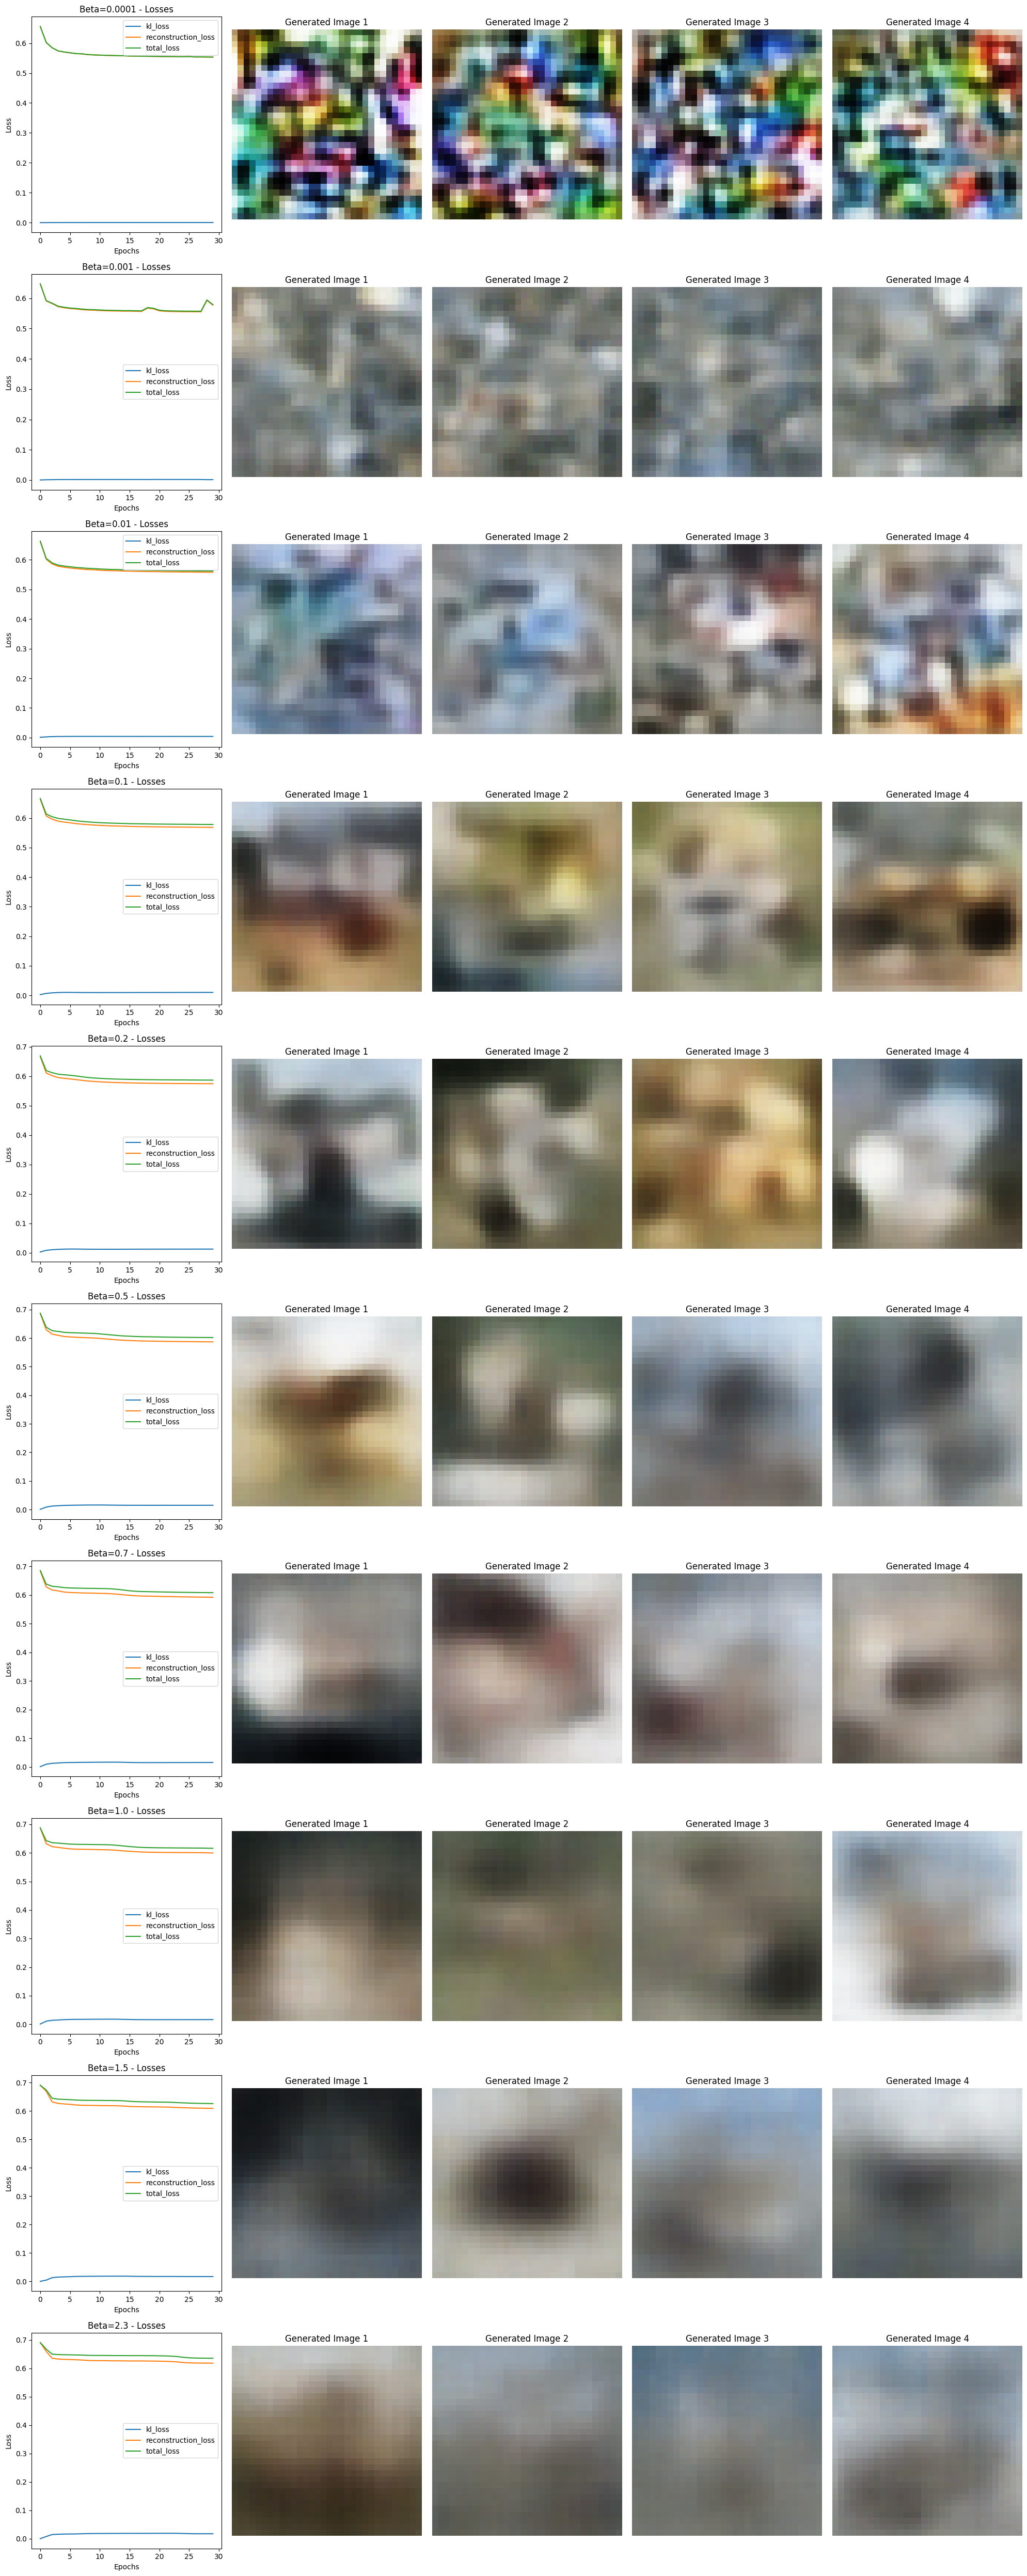

In [31]:
fig, axs = plt.subplots(len(beta_values), 5, figsize=(20, 5*len(beta_values)))  
loss_labels = ['kl_loss', 'reconstruction_loss', 'total_loss']
for i, (beta, loss_history, generated_images) in enumerate(zip(beta_values, loss_histories, generated_images_list)):
    for j, loss_label in enumerate(loss_labels):
        axs[i, 0].plot(loss_history[loss_label], label=loss_label)
    axs[i, 0].set_title(f'Beta={beta} - Losses')
    axs[i, 0].set_ylabel('Loss')
    axs[i, 0].set_xlabel('Epochs')
    axs[i, 0].legend()

    # Plot generated images
    for j in range(4):
        axs[i, j+1].imshow(generated_images[j])
        axs[i, j+1].set_title(f'Generated Image {j+1}')
        axs[i, j+1].axis('off')

plt.tight_layout()
plt.show()


In [32]:
generated_images = generate_images_from_latent_vectors(vae, 100)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


In [40]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = [resize(image, new_shape, 0) for image in images]
    return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# # Load pre-trained InceptionV3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

real_images = x_test[:100]  # Load your real images here

# Convert integer to floating point values
real_images = real_images.astype('float32')
generated_images = generated_images.astype('float32')

# Resize images to (299, 299, 3) as required by InceptionV3
real_images_resized = scale_images(real_images, (299, 299, 3))
generated_images_resized = scale_images(generated_images, (299, 299, 3))

# Preprocess images
real_images_preprocessed = preprocess_input(real_images_resized)
generated_images_preprocessed = preprocess_input(generated_images_resized)

# Calculate FID score between real and generated images
fid_score = calculate_fid(model, real_images_preprocessed, generated_images_preprocessed)
print('FID Score:', fid_score)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
FID Score: 9.798883247027893e+101
